# Download and install required packages

In [ ]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install gdown
!pip install Pillow
!pip install imageio

## Download dataset

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
To: /content/Project_data.zip
1.71GB [00:12, 141MB/s] 


In [ ]:
!unzip -q Project_data.zip

## Files Structure

In [ ]:
!ls
!echo "---"
!ls Project_data/
!echo "---"
!ls Project_data/val/ | head
!echo "---"
!ls Project_data/val/WIN_20180907_15_30_06_Pro_Right\ Swipe_new | head

Project_data  Project_data.zip	sample_data
---
train  train.csv  val  val.csv
---
WIN_20180907_15_30_06_Pro_Right Swipe_new
WIN_20180907_15_38_42_Pro_Thumbs Up_new
WIN_20180907_15_42_17_Pro_Stop Gesture_new
WIN_20180907_15_42_25_Pro_Thumbs Down_new
WIN_20180907_15_43_36_Pro_Thumbs Up_new
WIN_20180907_15_45_04_Pro_Left Swipe_new_Left Swipe_new
WIN_20180907_15_45_43_Pro_Right Swipe_new
WIN_20180907_15_47_33_Pro_Thumbs Down_new
WIN_20180907_15_50_39_Pro_Right Swipe_new
WIN_20180907_15_52_05_Pro_Thumbs Up_new
---
WIN_20180907_15_30_06_Pro_00015.png
WIN_20180907_15_30_06_Pro_00017.png
WIN_20180907_15_30_06_Pro_00019.png
WIN_20180907_15_30_06_Pro_00021.png
WIN_20180907_15_30_06_Pro_00023.png
WIN_20180907_15_30_06_Pro_00025.png
WIN_20180907_15_30_06_Pro_00027.png
WIN_20180907_15_30_06_Pro_00029.png
WIN_20180907_15_30_06_Pro_00031.png
WIN_20180907_15_30_06_Pro_00033.png


In [ ]:
!cat Project_data/train.csv | head

WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_21_28_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_22_55_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_24_49_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_26_25_Pro_Left_Swipe_new;Left_Swipe_new;0
WIN_20180925_17_26_51_Pro_Left_Swipe_new;Left_Swipe_new;0


In [ ]:
!mkdir models

# Imports 

In [ ]:
import numpy as np
import os
from scipy.misc import imread, imresize
# from imageio import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from PIL import Image
np.random.seed(30)
import random as rn
rn.seed(30)

We set the random seed so that the results don't vary drastically.

In [ ]:
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(1234)

In [ ]:
try:
    device_name = tf.test.gpu_device_name()
    print("Tensorflow version " + tf.__version__)

    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
except:
    pass

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    pass


Tensorflow version 2.4.1
Found GPU at: /device:GPU:0


In [ ]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTMInterview
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [ ]:
project_folder='Project_data'

In [ ]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
                # image_resized=Image.fromarray(image).resize(size=(self.image_height,self.image_width,3))
                # resized_img = Image.fromarray(orj_img).resize(size=(new_h, new_w))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'models/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

##### Sample Cropping

In [ ]:
#test_generator=ModelConv3D1()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,15,:,:,:])   
#axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - 56s 2s/step - loss: 1.8502 - categorical_accuracy: 0.3419 - val_loss: 3.2158 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to nms/model_init_2021-03-0819_32_56.855468/model-00001-1.59002-0.41176-3.21579-0.16000.h5
Epoch 2/3
23/23 [==============================] - 49s 2s/step - loss: 1.1085 - categorical_accuracy: 0.5434 - val_loss: 4.6664 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to nms/model_init_2021-03-0819_32_56.855468/model-00002-1.10306-0.56712-4.66642-0.16000.h5
Epoch 3/3
23/23 [==============================] - 48s 2s/step - loss: 0.9563 - categorical_accuracy: 0.6140 - val_loss: 5.0220 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to nms/model_init_2021-03-0819_32_56.855468/model-00003-0.91968-0.61991-5.02204-0.17000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - 88s 4s/step - loss: 1.9821 - categorical_accuracy: 0.2928 - val_loss: 1.8961 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to nms/model_init_2021-03-0819_35_33.365915/model-00001-1.66292-0.37406-1.89608-0.21000.h5
Epoch 2/2
23/23 [==============================] - 81s 4s/step - loss: 1.1855 - categorical_accuracy: 0.5450 - val_loss: 2.6603 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to nms/model_init_2021-03-0819_35_33.365915/model-00002-1.15708-0.55807-2.66032-0.20000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 86s 8s/step - loss: 1.7092 - categorical_accuracy: 0.3944 - val_loss: 1.6291 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to nms/model_init_2021-03-0819_38_24.990876/model-00001-1.57326-0.44193-1.62913-0.17000.h5
Epoch 2/2
12/12 [==============================] - 81s 7s/step - loss: 1.0680 - categorical_accuracy: 0.5672 - val_loss: 2.1958 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to nms/model_init_2021-03-0819_38_24.990876/model-00002-1.11502-0.56109-2.19585-0.16000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - 46s 4s/step - loss: 1.7199 - categorical_accuracy: 0.3698 - val_loss: 1.6863 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to nms/model_init_2021-03-0819_41_18.512239/model-00001-1.53570-0.42685-1.68631-0.16000.h5
Epoch 2/2
12/12 [==============================] - 43s 4s/step - loss: 1.1233 - categorical_accuracy: 0.5628 - val_loss: 2.6123 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to nms/model_init_2021-03-0819_41_18.512239/model-00002-1.10500-0.56109-2.61234-0.17000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - 48s 6s/step - loss: 1.9196 - categorical_accuracy: 0.3042 - val_loss: 1.5383 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to nms/model_init_2021-03-0819_42_50.819133/model-00001-1.75043-0.37406-1.53826-0.39000.h5
Epoch 2/2
9/9 [==============================] - 45s 6s/step - loss: 1.1985 - categorical_accuracy: 0.5168 - val_loss: 1.9465 - val_categorical_accuracy: 0.1600

Epoch 00002: saving model to nms/model_init_2021-03-0819_42_50.819133/model-00002-1.19511-0.52036-1.94654-0.16000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 106s 2s/step - loss: 1.7020 - categorical_accuracy: 0.3791 - val_loss: 5.7239 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to nms/model_init_2021-03-0819_44_27.651676/model-00001-1.53178-0.44344-5.72392-0.16000.h5
Epoch 2/2
45/45 [==============================] - 103s 2s/step - loss: 1.1415 - categorical_accuracy: 0.5691 - val_loss: 9.6780 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to nms/model_init_2021-03-0819_44_27.651676/model-00002-1.17232-0.56109-9.67800-0.17000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 61s 1s/step - loss: 1.8701 - categorical_accuracy: 0.3237 - val_loss: 3.7762 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to nms/model_init_2021-03-0819_47_59.240507/model-00001-1.59809-0.40121-3.77622-0.16000.h5
Epoch 2/2
45/45 [==============================] - 58s 1s/step - loss: 1.1567 - categorical_accuracy: 0.5464 - val_loss: 5.0418 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to nms/model_init_2021-03-0819_47_59.240507/model-00002-1.12218-0.58069-5.04183-0.13000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - 53s 1s/step - loss: 2.0969 - categorical_accuracy: 0.2761 - val_loss: 4.4298 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to nms/model_init_2021-03-0819_49_58.878135/model-00001-1.73584-0.36199-4.42976-0.21000.h5
Epoch 2/2
45/45 [==============================] - 52s 1s/step - loss: 1.2705 - categorical_accuracy: 0.4932 - val_loss: 7.1640 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to nms/model_init_2021-03-0819_49_58.878135/model-00002-1.24712-0.51131-7.16401-0.23000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 54s 789ms/step - loss: 1.8236 - categorical_accuracy: 0.3098 - val_loss: 4.4097 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to nms/model_init_2021-03-0819_51_45.058741/model-00001-1.63712-0.37406-4.40967-0.16000.h5
Epoch 2/2
67/67 [==============================] - 52s 793ms/step - loss: 1.2867 - categorical_accuracy: 0.4730 - val_loss: 4.8876 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to nms/model_init_2021-03-0819_51_45.058741/model-00002-1.23552-0.49170-4.88764-0.15000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - 95s 1s/step - loss: 1.8475 - categorical_accuracy: 0.3136 - val_loss: 5.1247 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to nms/model_init_2021-03-0819_53_32.217079/model-00001-1.64588-0.36652-5.12471-0.21000.h5
Epoch 2/2
67/67 [==============================] - 94s 1s/step - loss: 1.3030 - categorical_accuracy: 0.4933 - val_loss: 5.5145 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to nms/model_init_2021-03-0819_53_32.217079/model-00002-1.33252-0.49170-5.51452-0.20000.h5


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

##### As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

##### So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

In [ ]:
plot(history_model1)

##### Model is clearly overfitting. So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

In [ ]:
plot(history_model2)

##### Model is not overfitting and we get a best validation accuracy of 85% and training accuracy of 91%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x  120

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

In [ ]:
plot(history_model3)

##### Model has a  best validation accuracy of 84% and training accuracy of 84% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

In [ ]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

In [ ]:
plot(history_model5)

##### Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

##### All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

In [ ]:
plot(history_model6)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 7 - reducing the number of parameters

In [ ]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

In [ ]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 77%

# Model 8 - reducing the number of parameters

In [ ]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

In [ ]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

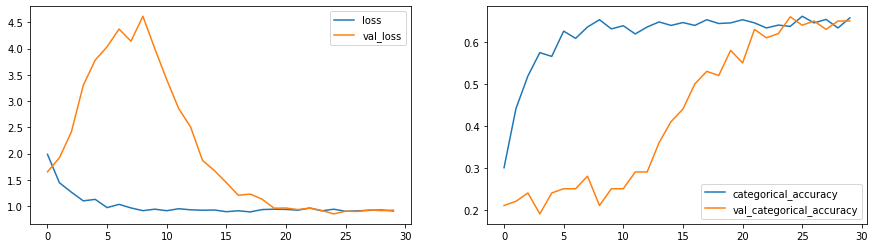

In [ ]:
plot(history_model8)

###### For the above low memory foot print model the best validation accuracy of 78%

# Model 9 - CNN- LSTM Model

In [ ]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

In [ ]:
plot(history_model9)

##### For CNN - LSTM model we get a best validation accuracy of 75%

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'models/' + 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
#class Test(ModelBuilderMoreAugmentation):
#    def define_model(self):
#        pass

#test_generator=Test()
#test_generator.initialize_path(project_folder)
#test_generator.initialize_image_properties(image_height=160,image_width=160)
#test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

#g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
#batch_data, batch_labels=next(g)
#fig, axes = plt.subplots(nrows=1, ncols=2)
#axes[0].imshow(batch_data[0,29,:,:,:])   
#axes[1].imshow(batch_data[3,29,:,:,:])   

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

In [ ]:
plot(history_model10)

# Model 11 - (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

In [ ]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

In [ ]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [ ]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

In [ ]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [ ]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

In [ ]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

In [ ]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

In [ ]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [ ]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

In [ ]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

In [ ]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [ ]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 16)    

In [ ]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - 81s 2s/step - loss: 2.1980 - categorical_accuracy: 0.2385 - val_loss: 1.7827 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-03-0813_49_13.491678/model-00001-1.99188-0.29487-1.78275-0.21000.h5
Epoch 2/30
34/34 [==============================] - 79s 2s/step - loss: 1.5579 - categorical_accuracy: 0.3848 - val_loss: 2.4934 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2021-03-0813_49_13.491678/model-00002-1.50989-0.41478-2.49342-0.19000.h5
Epoch 3/30
34/34 [==============================] - 79s 2s/step - loss: 1.3621 - categorical_accuracy: 0.4715 - val_loss: 3.0699 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-03-0813_49_13.491678/model-00003-1.37996-0.46380-3.06993-0.21000.h5
Epoch 4/30
34/34 [==============================] - 79s 2s/step - loss: 1.1754 - categorical_accuracy: 0.5461 - val_loss: 4.0165 - val_categorica

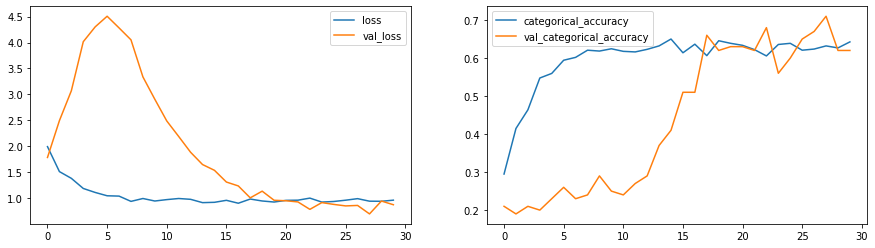

In [ ]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - 94s 3s/step - loss: 1.7056 - categorical_accuracy: 0.2797 - val_loss: 1.9094 - val_categorical_accuracy: 0.1700

Epoch 00001: saving model to model_init_2021-03-0814_33_04.646442/model-00001-1.53683-0.33937-1.90937-0.17000.h5
Epoch 2/20
34/34 [==============================] - 90s 3s/step - loss: 1.1226 - categorical_accuracy: 0.5531 - val_loss: 2.5091 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to model_init_2021-03-0814_33_04.646442/model-00002-1.07992-0.57164-2.50911-0.15000.h5
Epoch 3/20
34/34 [==============================] - 89s 3s/step - loss: 0.9278 - categorical_accuracy: 0.6374 - val_loss: 2.5439 - val_categorical_accuracy: 0.1700

Epoch 00003: saving model to model_init_2021-03-0814_33_04.646442/model-00003-0.89964-0.64329-2.54387-0.17000.h5
Epoch 4/20
34/34 [==============================] - 88s 3s/step - loss: 0.7462 - categorical_accuracy: 0.7247 - val_loss: 2.9431 - val_categoric

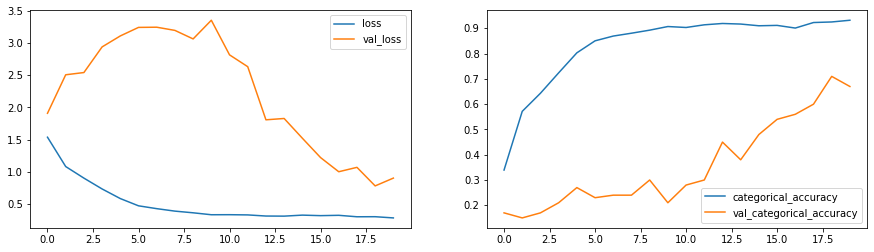

In [ ]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 82s 600ms/step - loss: 1.4974 - categorical_accuracy: 0.3432 - val_loss: 0.9930 - val_categorical_accuracy: 0.5700

Epoch 00001: saving model to model_init_2021-03-0815_02_56.125343/model-00001-1.36383-0.41855-0.99300-0.57000.h5
Epoch 2/20
133/133 [==============================] - 79s 600ms/step - loss: 0.9313 - categorical_accuracy: 0.6408 - val_loss: 0.6508 - val_categorical_accuracy: 0.8000

Epoch 00002: saving model to model_init_2021-03-0815_02_56.125343/model-00002-0.87833-0.65309-0.65082-0.80000.h5
Epoch 3/20
133/133 [==============================] - 79s 597ms/step - loss: 0.6754 - categorical_accuracy: 0.7617 - val_loss: 0.6287 - val_categorical_accuracy: 0.7700

Epoch 00003: saving model to model_init_2021-03-0815_02_56.125343/model-00003-0.66100-0.75792-0.62872-0.77000.h5
Epoch 4/20
133/133 [==============================] - 80s 603ms/step - loss: 0.5232 - categorical_accuracy: 0.8207 - val_loss: 0.

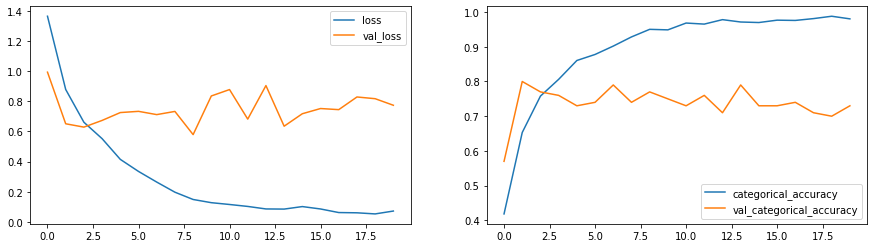

In [ ]:
plot(history_model18)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - 91s 656ms/step - loss: 1.4576 - categorical_accuracy: 0.4020 - val_loss: 0.8867 - val_categorical_accuracy: 0.6300

Epoch 00001: saving model to model_init_2021-03-0815_29_31.771567/model-00001-1.19523-0.51357-0.88672-0.63000.h5
Epoch 2/20
133/133 [==============================] - 87s 655ms/step - loss: 0.6278 - categorical_accuracy: 0.7547 - val_loss: 0.3681 - val_categorical_accuracy: 0.8100

Epoch 00002: saving model to model_init_2021-03-0815_29_31.771567/model-00002-0.63645-0.75792-0.36814-0.81000.h5
Epoch 3/20
133/133 [==============================] - 87s 654ms/step - loss: 0.5279 - categorical_accuracy: 0.7953 - val_loss: 0.5399 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2021-03-0815_29_31.771567/model-00003-0.52555-0.80090-0.53985-0.80000.h5
Epoch 4/20
133/133 [==============================] - 86s 651ms/step - loss: 0.3350 - categorical_accuracy: 0.8867 - val_loss: 0.

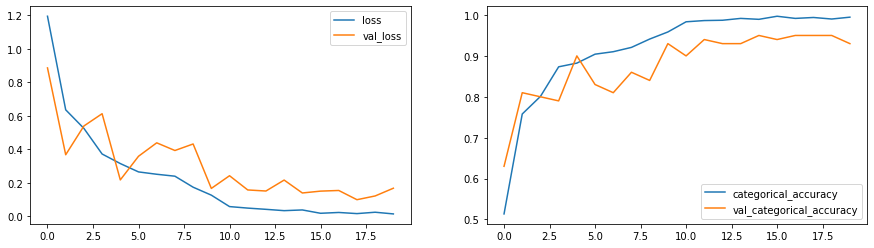

In [ ]:
plot(history_model19)

# Loading model and Testing

In [ ]:
import time
from keras.models import load_model
model = load_model('model-00020-0.27983-0.93213-0.89989-0.67000.h5')

In [ ]:
test_generator=RNNCNN2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=5,num_epochs=20)


g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 2 3 2 2]


In [ ]:
# test_generator2=RNNCNN2()
# test_generator2.initialize_path('test')
# test_generator2.initialize_image_properties(image_height=120,image_width=120)
# test_generator2.initialize_hyperparams(frames_to_sample=18,batch_size=5,num_epochs=20)


# g=test_generator2.generator(test_generator2.val_path,test_generator2.val_doc,augment=False)
# batch_data, batch_labels=next(g)

In [ ]:
# batch_labels

array([[0., 0., 0., 0., 1.]])

In [ ]:
# print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4]


In [ ]:
# !rm test/val/test_Pro_Thumbs_Up_new -r